<a href="https://colab.research.google.com/github/damsoumya/Basic_ML/blob/main/Regression_Predict-Fuel-Efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression: Predict Fuel Efficiency

##### This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, provide the model with a description of many automobiles from that time period.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)

In [ ]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset = dataset.dropna()
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [ ]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [ ]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(10, 8))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if x is not None and y is not None:
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

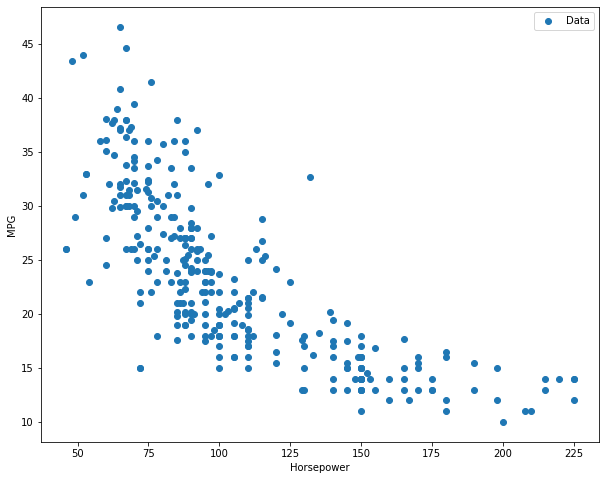

In [ ]:
plot('Horsepower')

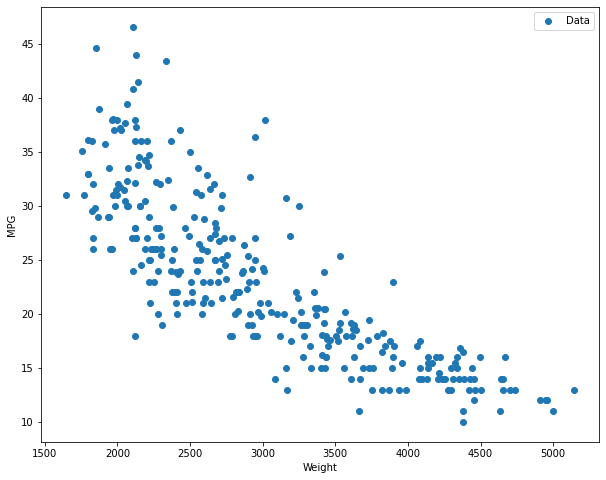

In [ ]:
plot('Weight')

In [ ]:
print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization
normalizer = preprocessing.Normalization()

# Adapt to data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
    0.197]


In [ ]:
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [ ]:
feature = 'Horsepower'
single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = preprocessing.Normalization()

# adapt to the data
single_feature_normalizer.adapt(single_feature)

(314,) (314, 9)


In [ ]:
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1) # Linear Model
])

In [ ]:
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
loss = keras.losses.MeanAbsoluteError() # MeanSquaredError
optim = keras.optimizers.Adam(lr=0.1)

single_feature_model.compile(optimizer=optim, loss=loss)

In [ ]:
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 3s 30ms/step - loss: 22.7793 - val_loss: 22.9393
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 21.8447 - val_loss: 22.1390
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 21.8984 - val_loss: 21.3390
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 20.6482 - val_loss: 20.5391
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 19.7117 - val_loss: 19.7391
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 19.8001 - val_loss: 18.9388
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 17.8490 - val_loss: 18.1392
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 17.3296 - val_loss: 17.3393
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 16.9570 - val_loss: 16.5401
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 15.3941 - val_loss: 15.7553
Epoch 11

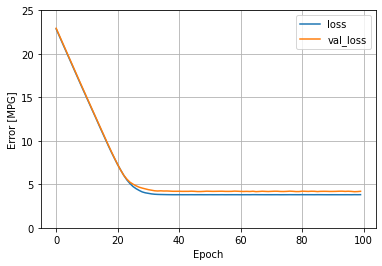

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [ ]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 3.6354


3.6353752613067627

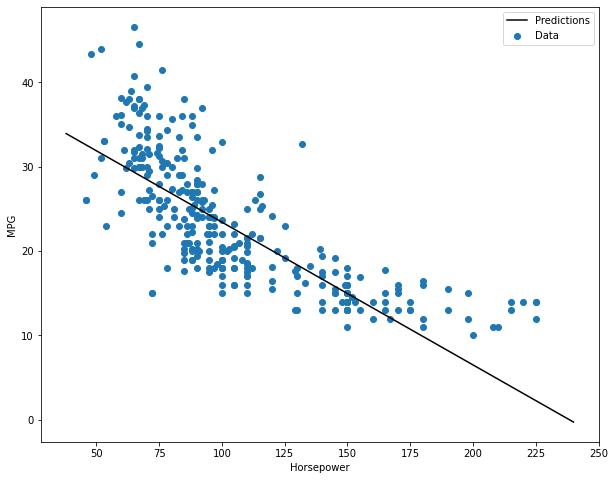

In [ ]:
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)
    
plot(feature, x,y)

In [ ]:
dnn_model = keras.Sequential([
    single_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [ ]:
dnn_model.compile(loss=loss, 
                  optimizer=tf.keras.optimizers.Adam(0.001))

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [ ]:
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 28ms/step - loss: 23.3091 - val_loss: 23.4895
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 22.0989 - val_loss: 23.2155
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 22.0491 - val_loss: 22.9321
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 22.4865 - val_loss: 22.5891
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 22.3648 - val_loss: 22.1571
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 21.4217 - val_loss: 21.6169
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 20.8066 - val_loss: 20.9353
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 19.7359 - val_loss: 20.0809
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 19.1554 - val_loss: 19.0688
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 18.0021 - val_loss: 17.9111
Epoch 11

In [ ]:
dnn_model.evaluate(test_features[feature], test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 2.9320


2.9320061206817627

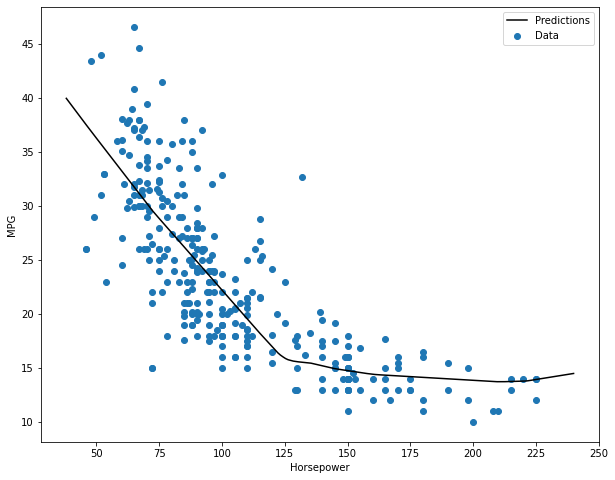

In [ ]:
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot(feature, x,y)

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=loss)

In [ ]:
linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 0s 25ms/step - loss: 22.9408 - val_loss: 22.8748
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 21.5130 - val_loss: 22.1924
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 20.8796 - val_loss: 21.4820
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 20.3414 - val_loss: 20.7512
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 19.8292 - val_loss: 20.0129
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 18.4369 - val_loss: 19.2971
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 17.8596 - val_loss: 18.5847
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 18.0403 - val_loss: 17.8677
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 16.4388 - val_loss: 17.1371
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 16.1874 - val_loss: 16.3970
Epoch 11

In [ ]:
linear_model.evaluate(
    test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 2.4441


2.4440793991088867